In [1102]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import *
from IPython.display import display, HTML, IFrame
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')


In [1103]:
#folder = ['compsci-data','jbt-data', 'brands-data-400', 'brands-data-100']
folder = ['jbt-data']

In [1104]:


agg_list = []
full_list = []
test_list = []
for f in folder:
    agg =  pd.read_csv('{}/agg.csv'.format(f))
    agg['type'] = f.split('-')[0]
    agg.set_index('id')
    agg_list.append(agg)
   
    full = pd.read_csv('{}/full.csv'.format(f))
    full['type'] = f.split('-')[0]
    full.set_index('id')
    full_list.append( full)
    test = pd.read_csv('{}/test.csv'.format(f))
    test['type'] = f.split('-')[0]
    test.set_index('id')
    test_list.append (test)
aggregated = pd.concat(agg_list)
full = pd.concat(full_list)
test_questions = pd.concat(test_list)
aggregated = aggregated[aggregated['_unit_state'] == 'finalized']


### Quality

In [1127]:
conf = aggregated[['id','text_readable', 'label:confidence', 'label']]
display(conf[['label:confidence']].describe())
print('Sentences 85%> confidence')
top_conf = conf[conf['label:confidence'] >= 0.85]
display(top_conf.count())
print('Sentences with a confidence between 0.60 and 0.80')
avg_conf = conf[(conf['label:confidence']<= 0.8) & (conf['label:confidence']>= 0.60)]
display(avg_conf.count())
print('Sentence with <60% confidence')
worst_conf = conf[conf['label:confidence'] <= 0.6]
display(worst_conf.count())

print('Useable sentences (conf >= 60%)')
useable = conf[conf['label:confidence'] >= 0.6]
display(useable.count())

out = aggregated[aggregated['label:confidence'] >= 0.6]

out.to_csv('out1.csv', index=False)



useable_worse = useable[useable['label'] == 'WORSE']
useable.to_csv("out.csv", index=False)

def print_info(data):
    avg = pd.merge(data, full, suffixes=['_l', '_r'], on=['id'], how='left')[['id', 'text_readable_r', 'label:confidence', 'label_l', 'label_r', '_trust','a','b', 'type']].sort_values(['label:confidence', 'id'])
    renamed_avg = avg.rename(columns={'label_l' : 'assigned', 'label_r' : 'proposed'})
    display( renamed_avg.style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn'),subset=['label:confidence']))
    display(renamed_avg.describe())
    renamed_avg['counter'] = renamed_avg['proposed']
    avg = renamed_avg[['counter','assigned','proposed']].groupby([ 'assigned', 'proposed']).count()
   
    display(avg)


,label:confidence
count,100.000000
mean,0.805121
std,0.197660
min,0.351200
25%,0.658650
50%,0.712750
75%,1.000000
max,1.000000


Sentences 85%> confidence


id                  47
text_readable       47
label:confidence    47
label               47
dtype: int64

Sentences with a confidence between 0.60 and 0.80


id                  47
text_readable       47
label:confidence    47
label               47
dtype: int64

Sentence with <60% confidence


id                  6
text_readable       6
label:confidence    6
label               6
dtype: int64

Useable sentences (conf >= 60%)


id                  94
text_readable       94
label:confidence    94
label               94
dtype: int64

**The hardest sentences**

In [1106]:
print_info(worst_conf)


,id,text_readable_r,label:confidence,assigned,proposed,_trust,a,b,type
9,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,OTHER,0.8333,baseball,softball,jbt
10,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,NONE,0.75,baseball,softball,jbt
11,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,WORSE,0.8571,baseball,softball,jbt
3,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,NONE,1,google,youtube,jbt
4,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,WORSE,0.8,google,youtube,jbt
5,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,OTHER,1,google,youtube,jbt
6,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,NONE,1,pizza,sausage,jbt
7,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,OTHER,0.75,pizza,sausage,jbt
8,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,WORSE,0.875,pizza,sausage,jbt
12,E705740896,Field sharpening requires a *stone* harder than §steel$ and a smooth stroke.,0.381,NONE,NONE,1,steel,stone,jbt


counter
assigned proposed         
BETTER   BETTER          1
         OTHER           1
         WORSE           1
NONE     NONE            2
         OTHER           2
         WORSE           2
OTHER    NONE            2
         OTHER           2
         WORSE           2
WORSE    NONE            1
         OTHER           1
         WORSE           1

**Average sentences**

In [1128]:
print_info(avg_conf)

,id,text_readable_r,label:confidence,assigned,proposed,_trust,a,b,type
12,P2469199001,"The *ds* versions looks really good, but §wii$ could look alot better.",0.6129,WORSE,BETTER,1,wii,ds,jbt
13,P2469199001,"The *ds* versions looks really good, but §wii$ could look alot better.",0.6129,WORSE,WORSE,0.75,wii,ds,jbt
14,P2469199001,"The *ds* versions looks really good, but §wii$ could look alot better.",0.6129,WORSE,WORSE,0.8333,wii,ds,jbt
9,A109112123,95% of the the things I do with my *laptop* on the road will be accomplished far easier and faster with the §iphone$.,0.6158,WORSE,BETTER,1,laptop,iphone,jbt
10,A109112123,95% of the the things I do with my *laptop* on the road will be accomplished far easier and faster with the §iphone$.,0.6158,WORSE,WORSE,0.7692,laptop,iphone,jbt
11,A109112123,95% of the the things I do with my *laptop* on the road will be accomplished far easier and faster with the §iphone$.,0.6158,WORSE,WORSE,0.8333,laptop,iphone,jbt
120,M1970249378,Particularly during the cooler months (when *camping* is most enjoyable) §fishing$ for both reds and seatrout can be excellent.,0.6158,NONE,NONE,0.8333,fishing,camping,jbt
121,M1970249378,Particularly during the cooler months (when *camping* is most enjoyable) §fishing$ for both reds and seatrout can be excellent.,0.6158,NONE,NONE,0.7692,fishing,camping,jbt
122,M1970249378,Particularly during the cooler months (when *camping* is most enjoyable) §fishing$ for both reds and seatrout can be excellent.,0.6158,NONE,BETTER,1,fishing,camping,jbt
51,S3010092116,"Vudu offers better quality, *amazon* often has better pricing and for catalog titles, Netflix and §hulu$ are both ahead.",0.6158,OTHER,BETTER,1,amazon,hulu,jbt


,label:confidence,_trust
count,141.000000,141.000000
mean,0.665460,0.855923
std,0.030205,0.083327
min,0.612900,0.714300
25%,0.640400,0.800000
50%,0.665500,0.833300
75%,0.684200,0.888900
max,0.727300,1.000000


counter
assigned proposed         
BETTER   BETTER         12
         NONE            5
         OTHER           1
NONE     BETTER          2
         NONE           50
         OTHER          22
         WORSE           1
OTHER    BETTER          1
         NONE            7
         OTHER          22
         WORSE           3
WORSE    BETTER          3
         NONE            1
         OTHER           1
         WORSE          10

**Easy sentences**

In [1130]:
print_info(top_conf)

,id,text_readable_r,label:confidence,assigned,proposed,_trust,a,b,type
21,A58777035,2) *basketball* recruiting is slower than §football$.,1,WORSE,WORSE,0.8889,football,basketball,jbt
22,A58777035,2) *basketball* recruiting is slower than §football$.,1,WORSE,WORSE,0.8333,football,basketball,jbt
23,A58777035,2) *basketball* recruiting is slower than §football$.,1,WORSE,WORSE,1,football,basketball,jbt
42,A77783944,"3. You would have a decent shot at North *carolina*, Carnegie Mellon, Duke, Darden, Rochester, and perhaps §michigan$ (longer shot).",1,NONE,NONE,1,carolina,michigan,jbt
43,A77783944,"3. You would have a decent shot at North *carolina*, Carnegie Mellon, Duke, Darden, Rochester, and perhaps §michigan$ (longer shot).",1,NONE,NONE,0.75,carolina,michigan,jbt
44,A77783944,"3. You would have a decent shot at North *carolina*, Carnegie Mellon, Duke, Darden, Rochester, and perhaps §michigan$ (longer shot).",1,NONE,NONE,0.8333,carolina,michigan,jbt
3,B317690396,"Anyway, between Beck and Lou Dobbs, *cnn* is frequently far worse than §fox$ News.",1,WORSE,WORSE,1,fox,cnn,jbt
4,B317690396,"Anyway, between Beck and Lou Dobbs, *cnn* is frequently far worse than §fox$ News.",1,WORSE,WORSE,0.8,fox,cnn,jbt
5,B317690396,"Anyway, between Beck and Lou Dobbs, *cnn* is frequently far worse than §fox$ News.",1,WORSE,WORSE,0.8889,fox,cnn,jbt
33,C358392517,"As good as *michigan* has been defensively this season, §virginia$ has been even better.",1,WORSE,WORSE,0.7692,virginia,michigan,jbt


,label:confidence,_trust
count,141.0,141.000000
mean,1.0,0.849111
std,0.0,0.091118
min,1.0,0.714300
25%,1.0,0.769200
50%,1.0,0.833300
75%,1.0,0.888900
max,1.0,1.000000


,,counter
assigned,proposed,
NONE,NONE,99
OTHER,OTHER,12
WORSE,WORSE,30


**All Sentences**

In [1129]:
print_info(conf)

,id,text_readable_r,label:confidence,assigned,proposed,_trust,a,b,type
174,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,OTHER,0.8333,baseball,softball,jbt
175,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,NONE,0.75,baseball,softball,jbt
176,N2140324436,"Schutt 2966 Molded Color *baseball* or §softball$ Catcher's Helmet Better looks, better performance and better protection.",0.3512,WORSE,WORSE,0.8571,baseball,softball,jbt
99,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,NONE,1,google,youtube,jbt
100,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,WORSE,0.8,google,youtube,jbt
101,F824714917,*google* released their own §youtube$ app that is far superior.,0.3571,OTHER,OTHER,1,google,youtube,jbt
102,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,NONE,1,pizza,sausage,jbt
103,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,OTHER,0.75,pizza,sausage,jbt
104,D400037625,But I would like *sausage* §pizza$ even better!,0.381,NONE,WORSE,0.875,pizza,sausage,jbt
192,E705740896,Field sharpening requires a *stone* harder than §steel$ and a smooth stroke.,0.381,NONE,NONE,1,steel,stone,jbt


,label:confidence,_trust
count,300.000000,300.000000
mean,0.805121,0.853759
std,0.196997,0.088119
min,0.351200,0.714300
25%,0.658650,0.769200
50%,0.712750,0.833300
75%,1.000000,0.888900
max,1.000000,1.000000


counter
assigned proposed         
BETTER   BETTER         13
         NONE            5
         OTHER           2
         WORSE           1
NONE     BETTER          2
         NONE          151
         OTHER          24
         WORSE           3
OTHER    BETTER          1
         NONE            9
         OTHER          36
         WORSE           5
WORSE    BETTER          3
         NONE            2
         OTHER           2
         WORSE          41

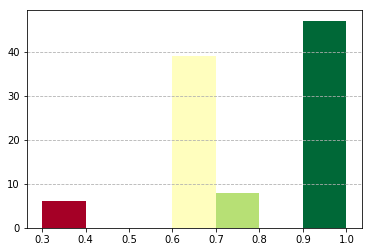

In [1110]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

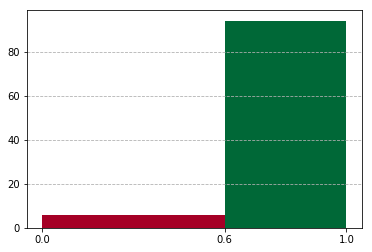

In [1111]:
color_map = plt.cm.get_cmap('RdYlGn')
#plt.title('Confidence of Labeling')
plt.grid(axis='y', linestyle='dashed')
ticks = [0.0,  0.6, 1]
plt.xticks(ticks)
n, bins, patches = plt.hist(
    aggregated['label:confidence'], bins=ticks, color='green')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', color_map(c))
plt.show()

## Results

**Label Distribution**

In [1112]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def show_dist(labels):

    plt.figure(figsize=plt.figaspect(1))
    plt.pie(
        labels.value_counts().values,
        labels=labels.value_counts().keys().tolist(),
        radius=2,
        autopct=make_autopct(labels.value_counts().values))
    plt.show()


**All sentences**

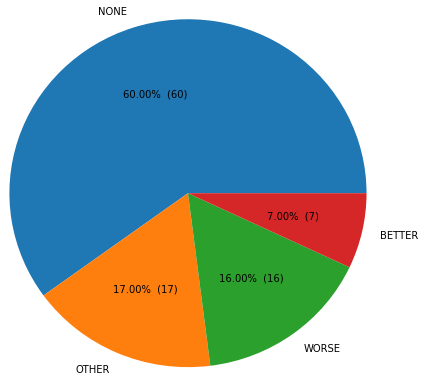

In [1113]:
show_dist(aggregated['label'])

**Sentences with conf > 60**

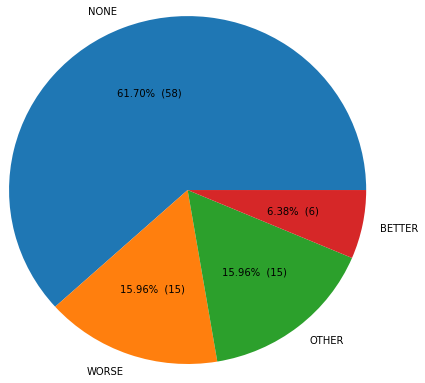

In [1114]:
show_dist(useable['label'])

## Test Sentences

In [1115]:
display(test_questions[['_pct_missed']].describe())

,_pct_missed
count,51.000000
mean,0.283725
std,0.236846
min,0.000000
25%,0.110000
50%,0.210000
75%,0.390000
max,0.880000


In [1116]:
print("Amount of test-questions without failures:")
display(test_questions[test_questions['_pct_missed'] == 0]['_pct_missed'].count())

print("Amount of test questions missed 50%>")
display(test_questions[test_questions['_pct_missed'] >= 0.5]['_pct_missed'].count())

print("Amount of test questions missed 80%>")
display(test_questions[test_questions['_pct_missed'] >= 0.8]['_pct_missed'].count())

Amount of test-questions without failures:


8

Amount of test questions missed 50%>


11

Amount of test questions missed 80%>


3

In [1117]:
highly_missed = test_questions[test_questions['_pct_missed'] >= 0.6]
proj = highly_missed[['id', 'text_readable', '_pct_missed', '_judgments', 'label_gold', 'type' ]]
proj.sort_values(['_pct_missed','id'])#.style.background_gradient(cmap=plt.cm.get_cmap('RdYlGn_r'),subset=['_pct_missed'])

,id,text_readable,_pct_missed,_judgments,label_gold,type
40,S2969144027,Unfortunately the crimes get progressively wor...,0.60,15,OTHER,jbt
9,R2922605663,To make things worse Joy has scheduled the *we...,0.62,8,NONE,jbt
14,K1722396834,"*mit* is often viewed as ""inbreeding central"":...",0.67,3,OTHER,jbt
4,N2239679026,"So, is *google* Plus better than §facebook$?",0.71,14,NONE,jbt
0,P2533877672,The Jimmy Dean *sandwich* had far better §saus...,0.82,11,OTHER,jbt
8,I1350818111,Is Netflix better than *hulu* Plus or §amazon$...,0.88,8,NONE,jbt
3,L1806350316,"*nixon* was better in the second, gerald ford ...",0.88,8,OTHER,jbt


**Contested Test-Questions**

In [1118]:
contested = test_questions[test_questions['_pct_contested'] != 0]
display(contested[['_pct_missed', '_judgments', '_pct_contested']].describe())

,_pct_missed,_judgments,_pct_contested
count,2.000000,2.000000,2.000000
mean,0.410000,10.000000,0.101000
std,0.579828,1.414214,0.014284
min,0.000000,9.000000,0.090900
25%,0.205000,9.500000,0.095950
50%,0.410000,10.000000,0.101000
75%,0.615000,10.500000,0.106050
max,0.820000,11.000000,0.111100


In [1119]:
display(contested[['id', 'text_readable', '_pct_missed', '_pct_contested', '_judgments', 'label_gold','type' ]].sort_values([ '_pct_contested', '_pct_missed']))

,id,text_readable,_pct_missed,_pct_contested,_judgments,label_gold,type
0,P2533877672,The Jimmy Dean *sandwich* had far better §saus...,0.82,0.0909,11,OTHER,jbt
43,E697369047,"Faster-paced sports, such as *basketball* and ...",0.00,0.1111,9,OTHER\nNONE,jbt


In [1120]:
from orderedset import OrderedSet

aggregated['pair'] = aggregated.apply(lambda row: ', '.join(sorted([row['a'], row['b']])),axis=1)

In [1139]:
#display(aggregated[['pair', 'id']].groupby(['pair']).count())

with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    display(aggregated[['a','b', 'id']].groupby(['a','b']).count())
    
    #f = np.append(aggregated['a'].values ,aggregated['b'].values)
    #print('Objects')
    #display(pd.value_counts(f, sort=True).to_frame())
    #print('Pairs')
    #display(pd.value_counts(aggregated['pair'].values,sort=True).to_frame())


id
a           b               
amazon      facebook       1
            hulu           1
            youtube        1
baseball    hockey         1
            softball       2
            tennis         1
basketball  hockey         1
beer        juice          1
            soda           1
            tea            2
bread       potato         1
            steak          1
california  carolina       3
carolina    michigan       2
            missouri       2
            pennsylvania   1
chocolate   soda           1
ds          ps3            1
facebook    youtube        3
fishing     camping        1
football    basketball     1
            golf           1
            hockey         1
fox         cnn            1
georgia     carolina       1
            michigan       1
            missouri       1
            oregon         1
golf        tennis         2
google      amazon         2
            itunes         1
            youtube        2
harvard     stanford       1
holiday     wedding        1
iphone      ipod           1
juice       cider          2
knife       pistol         3
laptop      iphone         1
lumber      plywood        1
metal       concrete       1
michigan    missouri       1
            oregon         2
milk        tea            1
mobile      wallet         1
mouse       rat            1
phone       laptop         2
pizza       pasta          1
            sandwich       1
            sausage        2
plastic     concrete       1
playstation gamecube       1
psp         ps3            1
reagan      nixon          1
sandwich    sausage        2
            steak          1
soup        pizza          1
            sandwich       3
stanford    mit            2
steel       aluminum       1
            stone          1
stone       concrete       1
suv         jeep           1
swimming    skiing         1
tea         chocolate      1
            juice          1
            soda           1
tennis      volleyball     2
virginia    michigan       1
wedding     birthday       1
wii         ds             1
            gamecube       1
            ps2            1
            psp            1
wood        cement         1
            foam           3
            rubber         1

In [1122]:
print('--')

--
